In [1]:
# This should be in a function...

def GetChildren(iCurrentParticle, pfpSelfList, pfpParentSelfList, hierarchyList) :
    
    hierarchyList.append(iCurrentParticle)
    
    for iParticle in range(pfpParentSelfList.shape[0]) :
        if (pfpParentSelfList[iParticle] == pfpSelfList[iCurrentParticle]) :
            GetChildren(iParticle, pfpSelfList, pfpParentSelfList, hierarchyList)


In [2]:
# This should be in a function...

def GetIvysaurusScore(iCurrentParticle, pfpTruePDGList, pfpIvysaurusMuonList, pfpIvysaurusProtonList, pfpIvysaurusPionList, pfpIvysaurusPhotonList, pfpIvysaurusElectronList) :
    
    absPDG = abs(pfpTruePDGList[iCurrentParticle])
    
    if (absPDG == 13) :
        return pfpIvysaurusMuonList[iCurrentParticle]
    elif (absPDG == 2212) :
        return pfpIvysaurusProtonList[iCurrentParticle]
    elif (absPDG == 211) :
        return pfpIvysaurusPionList[iCurrentParticle]
    elif (absPDG == 22) :
        return pfpIvysaurusPhotonList[iCurrentParticle]
    elif (absPDG == 11) :
        return pfpIvysaurusElectronList[iCurrentParticle]
    else :
        return -1

In [3]:
# Alright, lets begin...

In [4]:
# for creating a responsive plot
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib ipympl

In [5]:
import uproot
import torch
from torch_geometric.nn import GraphSAGE

import VisualisationFileHelper
import GraphBuilder
import Models 
from HigherTier import HigherTierFileHelper

In [6]:
from termcolor import colored, cprint

# Colour Dictionaries
pdgColours_text = {13 : 'blue', 11 : 'red', 2212 : 'green', 211 : 'magenta', 22 : 'yellow'}
pdgColours_graph = {13 : 'blue', 11 : 'red', 2212 : 'green', 211 : 'pink', 22 : 'tab:orange'}
hierarchyColours = {1 : 'black', 2 : 'red', 3 : 'blue', 4: 'g'}

In [7]:
# Target event info

fileName = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/HigherTier/files/handScan/event0.root'

In [8]:
treeFile = uproot.open(fileName)
tree = treeFile['ccnuselection/ccnusel']
branches = tree.arrays()

run = np.array(branches['Run'])
subrun = np.array(branches['SubRun'])
event = np.array(branches['Event'])

targetRun = run[0]
targetSubrun = subrun[0]
targetEvent = event[0]

In [9]:
# Read the file

isNC, nuPDG, recoNuX, recoNuY, recoNuZ, \
pfpSelf, pfpRecoGeneration, pfpRecoParentSelf, \
trackRecoStartX, trackRecoStartY, trackRecoStartZ, \
pfpSpacepointX, pfpSpacepointY, pfpSpacepointZ, \
pfpTrackShowerScore, pfpNHits, pfpCharge, \
pfpRecoVertexX, pfpRecoVertexY, pfpRecoVertexZ, \
trackRecoEndX, trackRecoEndY, trackRecoEndZ, \
showerDirX, showerDirY, showerDirZ, \
pfpIvysaurusMuon, pfpIvysaurusProton, pfpIvysaurusPion, \
pfpIvysaurusPhoton, pfpIvysaurusElectron, \
pfpTrackLength, pfpDisplacement, pfpDCA, pfpIsNeutrinoPDG, \
pfpNuVertexEnergyAsymmetry, pfpNuVertexEnergyWeightedMeanRadialDistance, \
pfpTrueMomX, pfpTrueMomY, pfpTrueMomZ, \
pfpTrueTrackID, pfpCompleteness, pfpPurity, pfpTruePDG, pfpTrueGeneration, \
pfpTrueParentTrackID, pfpTrueParentPDG, pfpTrueVisibleGeneration, \
pfpTrueVisibleParentTrackID, pfpTrueVisibleParentPDG = VisualisationFileHelper.readTree(fileName, targetRun, targetSubrun, targetEvent)

trueVisibleParentPFPIndex = np.array(branches['RecoPFPTrueVisibleParentPFPIndex'][0])


childX = np.array(branches['ChildStartX'][0])
childY = np.array(branches['ChildStartY'][0])
childZ = np.array(branches['ChildStartZ'][0])
childDX = np.array(branches['ChildStartDX'][0])
childDY = np.array(branches['ChildStartDY'][0])
childDZ = np.array(branches['ChildStartDZ'][0])

parentX = np.array(branches['ParentEndX'][0])
parentY = np.array(branches['ParentEndY'][0])
parentZ = np.array(branches['ParentEndZ'][0])
parentDX = np.array(branches['ParentEndDX'][0])
parentDY = np.array(branches['ParentEndDY'][0])
parentDZ = np.array(branches['ParentEndDZ'][0])

parentStartX = np.array(branches['ParentStartX'][0])
parentStartY = np.array(branches['ParentStartY'][0])
parentStartZ = np.array(branches['ParentStartZ'][0])
parentStartDX = np.array(branches['ParentStartDX'][0])
parentStartDY = np.array(branches['ParentStartDY'][0])
parentStartDZ = np.array(branches['ParentStartDZ'][0])

connectionPointX = np.array(branches['ChildConnectionX'][0])
connectionPointY = np.array(branches['ChildConnectionY'][0])
connectionPointZ = np.array(branches['ChildConnectionZ'][0])
connectionPointDX = np.array(branches['ChildConnectionDX'][0])
connectionPointDY = np.array(branches['ChildConnectionDY'][0])
connectionPointDZ = np.array(branches['ChildConnectionDZ'][0])

childPFPIndex = np.array(branches['ChildPFPIndex'][0])
parentPFPIndex = np.array(branches['ParentPFPIndex'][0])

extrapDistance = np.array(branches['ChildConnectionExtrapDistance'][0])
childConnectionLRatio = np.array(branches['ChildConnectionLRatio'][0])
overshootStartL = np.array(branches['OvershootStartL'][0])
childConnectionDCA = np.array(branches['ChildConnectionDCA'][0])
parentConnectionPointOpeningAngle = np.array(branches['ParentConnectionPointOpeningAngle'][0])
parentConnectionPointNUpstreamHits = np.array(branches['ParentConnectionPointNUpstreamHits'][0])
parentConnectionPointNDownstreamHits = np.array(branches['ParentConnectionPointNDownstreamHits'][0])

nParticles = pfpTruePDG.shape[0]

This should be one:  1


In [10]:
print(connectionPointX[23])

-9999.0


In [11]:
# Get hierarchy in print format

hierarchyList_reco = []

for iParticle in range(nParticles) : 
    if (pfpRecoGeneration[iParticle] == 2) :
        GetChildren(iParticle, pfpSelf, pfpRecoParentSelf, hierarchyList_reco)
      

In [12]:
#Print out the hierarchy
        
print(('CC' if not isNC else 'NC'), ('nue' if nuPDG == 12 else ('numu' if nuPDG == 14 else 'nutau')))
        
for iParticle in hierarchyList_reco :
    
    if (np.array(pfpSpacepointX[iParticle]).shape[0] == 0) :
        continue
    
    if (pfpRecoGeneration[iParticle] == 2) :
        print('-------------------------------------')
    
    space = "------" * (pfpRecoGeneration[iParticle] - 2) + " "
    
    print(space + 'Matched TrackID:', str(pfpTrueTrackID[iParticle]) + ', Matched Particle PDG:', colored(pfpTruePDG[iParticle], pdgColours_text.get(abs(pfpTruePDG[iParticle]), 'light_grey')))
    print(space + 'Ivysaurus Score:', GetIvysaurusScore(iParticle, pfpTruePDG, pfpIvysaurusMuon, \
          pfpIvysaurusProton, pfpIvysaurusPion, pfpIvysaurusPhoton, pfpIvysaurusElectron))
    print(space, ' True: Generation =', str(pfpTrueGeneration[iParticle]) + \
          ', Parent TrackID =', str(pfpTrueParentTrackID[iParticle]) + \
          ', Parent PDG =', colored(pfpTrueParentPDG[iParticle], pdgColours_text.get(abs(pfpTrueParentPDG[iParticle]), 'light_grey')))
    print(space, ' True Visible: Generation =', str(pfpTrueVisibleGeneration[iParticle]) + \
          ', Parent TrackID =', str(pfpTrueVisibleParentTrackID[iParticle]) + \
          ', Parent PDG =', colored(pfpTrueVisibleParentPDG[iParticle], pdgColours_text.get(abs(pfpTrueVisibleParentPDG[iParticle]), 'light_grey')))

print('-------------------------------------')

CC numu
-------------------------------------
 Matched TrackID: 1, Matched Particle PDG: 13
 Ivysaurus Score: 0.9113862
   True: Generation = 2, Parent TrackID = 0, Parent PDG = -1
   True Visible: Generation = 2, Parent TrackID = 0, Parent PDG = -1
------ Matched TrackID: 1, Matched Particle PDG: 13
------ Ivysaurus Score: 0.023621501
------   True: Generation = 2, Parent TrackID = 0, Parent PDG = -1
------   True Visible: Generation = 2, Parent TrackID = 1, Parent PDG = -1
-------------------------------------
 Matched TrackID: 3, Matched Particle PDG: 211
 Ivysaurus Score: 0.9991185
   True: Generation = 2, Parent TrackID = 0, Parent PDG = -1
   True Visible: Generation = 2, Parent TrackID = 0, Parent PDG = -1
------ Matched TrackID: 11, Matched Particle PDG: 211
------ Ivysaurus Score: 0.9977429
------   True: Generation = 3, Parent TrackID = 3, Parent PDG = 211
------   True Visible: Generation = 3, Parent TrackID = 3, Parent PDG = 211
------ Matched TrackID: 13, Matched Particle 

-------------------------------------


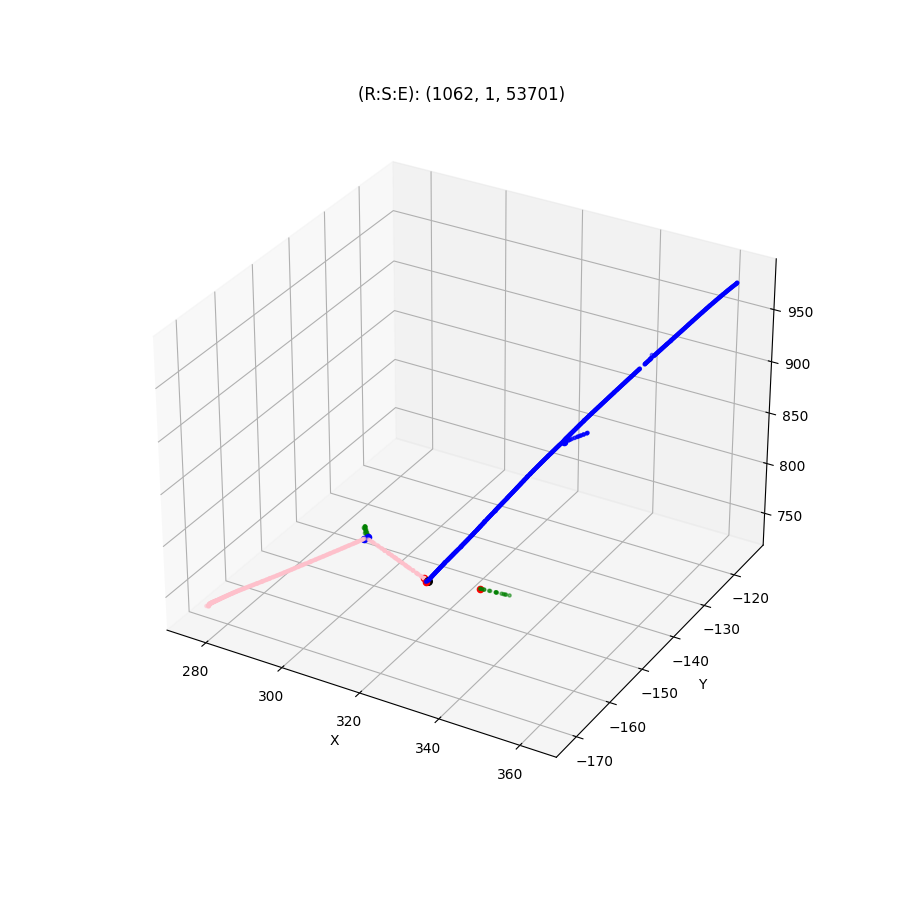

In [13]:
# NuVertex
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection='3d')

ax.scatter(recoNuX, recoNuY, recoNuZ, color = "black", s = 30.0)
plt.title('(R:S:E): (' + str(targetRun) + ", " + str(targetSubrun) + ", " + str(targetEvent) + ")")
plt.xlabel('X')
plt.ylabel('Y')

for iParticle in range(nParticles) : 
    
    if (np.array(pfpSpacepointX[iParticle]).shape[0] == 0) :
        continue
    
    x = np.array(pfpSpacepointX[iParticle])
    y = np.array(pfpSpacepointY[iParticle])
    z = np.array(pfpSpacepointZ[iParticle])
    
    vertexX = pfpRecoVertexX[iParticle]
    vertexY = pfpRecoVertexY[iParticle]
    vertexZ = pfpRecoVertexZ[iParticle]
    
    ax.scatter(x, y, z, color = pdgColours_graph.get(abs(pfpTruePDG[iParticle]), 'tab:gray'), s = 5.0, alpha = 0.5)
    ax.scatter(vertexX, vertexY, vertexZ, color = hierarchyColours.get(pfpRecoGeneration[iParticle], 'tab:gray'), s = 20.0)


print('-------------------------------------')

# show plot
plt.show()

#### plot only reco.. 

In [14]:
# Construct the graph building dictionary

eventDict = {
    "recoNuVertexX"                            : recoNuX, \
    "recoNuVertexY"                            : recoNuY, \
    "recoNuVertexZ"                            : recoNuZ, \
    "nParticles"                               : nParticles, \
    "trackShowerScore"                         : pfpTrackShowerScore, \
    "nHits"                                    : pfpNHits, \
    "charge"                                   : pfpCharge, \
    "vertexX"                                  : pfpRecoVertexX, \
    "vertexY"                                  : pfpRecoVertexY, \
    "vertexZ"                                  : pfpRecoVertexZ, \
    "trackEndX"                                : trackRecoEndX, \
    "trackEndY"                                : trackRecoEndY, \
    "trackEndZ"                                : trackRecoEndZ, \
    "showerDirX"                               : showerDirX, \
    "showerDirY"                               : showerDirY, \
    "showerDirZ"                               : showerDirZ, \
    "ivysaurusMuon"                            : pfpIvysaurusMuon, \
    "ivysaurusProton"                          : pfpIvysaurusProton, \
    "ivysaurusPion"                            : pfpIvysaurusPion, \
    "ivysaurusElectron"                        : pfpIvysaurusElectron, \
    "ivysaurusPhoton"                          : pfpIvysaurusPhoton, \
    "trackLength"                              : pfpTrackLength, \
    "displacement"                             : pfpDisplacement, \
    "dca"                                      : pfpDCA, \
    "isNeutrinoPDG"                            : pfpIsNeutrinoPDG, \
    "nuVertexEnergyAsymmetry"                  : pfpNuVertexEnergyAsymmetry, \
    "nuVertexEnergyWeightedMeanRadialDistance" : pfpNuVertexEnergyWeightedMeanRadialDistance, \
    "trueTrackID"                              : pfpTrueTrackID, \
    "trueVisibleParentTrackID"                 : pfpTrueVisibleParentTrackID, \
    "trueMomX"                                 : pfpTrueMomX, \
    "trueMomY"                                 : pfpTrueMomY, \
    "trueMomZ"                                 : pfpTrueMomZ, \
    "truePDG"                                  : pfpTruePDG, \
    "trueVisibleGeneration"                    : pfpTrueVisibleGeneration
}

modeDict = {
    "ADD_NEUTRINO"                 : True,
    "CHEAT_DIRECTION"              : True,
    "CHEAT_PID"                    : True, 
    "MAKE_PARTICLE_PARTICLE_LINKS" : True,
    "EDGE_FRACTION"                : 0.8,
    "DO_NORMALISATION"             : True,
    "IS_PRIMARY_TRAINING"          : False,
    "IS_HIGHER_TIER_TRAINING"      : False,
    "MAX_NODE_CLASS"               : 4
}


In [15]:
data_pos, data_neg, data_FC, pfp_index = GraphBuilder.GraphBuilder(eventDict, modeDict)

eventDict - isNu: [0 0 0 0 0 0 1]
pfpIndex: [0, 1, 2, 3, 4, 5, 6]
trueTrackID: [  1  11   3   1  13 460   0]
true parent: [   0    3    0    1    3    0 -999]
iSourceParticle: 0
iTargetParticle: 1
sourcePFPIndex: 0
targetPFPIndex: 1
is source nu? 0
is target nu? 0
source track ID: 1
target parent track ID: 3
iParent: 1
iChild: 0
iSourceParticle: 0
iTargetParticle: 2
sourcePFPIndex: 0
targetPFPIndex: 2
is source nu? 0
is target nu? 0
source track ID: 1
target parent track ID: 0
iParent: 2
iChild: 0
iSourceParticle: 0
iTargetParticle: 3
sourcePFPIndex: 0
targetPFPIndex: 3
is source nu? 0
is target nu? 0
source track ID: 1
target parent track ID: 1
iParent: 0
iChild: 3
iSourceParticle: 0
iTargetParticle: 4
sourcePFPIndex: 0
targetPFPIndex: 4
is source nu? 0
is target nu? 0
source track ID: 1
target parent track ID: 3
iParent: 4
iChild: 0
iSourceParticle: 0
iTargetParticle: 5
sourcePFPIndex: 0
targetPFPIndex: 5
is source nu? 0
is target nu? 0
source track ID: 1
target parent track ID: 0
iP

In [16]:
#########################################################
'''
# Config for our model (I'm annoyed it's here too tbh)
#########################################################

N_NODE_FEATURES = data_FC.num_features
HIDDEN_CHANNELS = 16
NUM_LAYERS = 2
USE_GRAPHSAGE = True

GNN_MODEL_PATH = "/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/gnn_model_primaries_oneway.pt"
CLASSIFICATION_MODEL_PATH = "/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/classifier_model_primaries_oneway.pt"

############################
# Setup the model for eval
############################

if (USE_GRAPHSAGE) :
    gnn_model = GraphSAGE(N_NODE_FEATURES, hidden_channels=HIDDEN_CHANNELS, num_layers=NUM_LAYERS)
else :
    gnn_model = Models.GNN(N_NODE_FEATURES, HIDDEN_CHANNELS)

classifier_model = Models.Classifier()


gnn_model.load_state_dict(torch.load(GNN_MODEL_PATH))
gnn_model.eval()

classifier_model.load_state_dict(torch.load(CLASSIFICATION_MODEL_PATH))
classifier_model.eval()
'''

'\n# Config for our model (I\'m annoyed it\'s here too tbh)\n#########################################################\n\nN_NODE_FEATURES = data_FC.num_features\nHIDDEN_CHANNELS = 16\nNUM_LAYERS = 2\nUSE_GRAPHSAGE = True\n\nGNN_MODEL_PATH = "/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/gnn_model_primaries_oneway.pt"\nCLASSIFICATION_MODEL_PATH = "/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/classifier_model_primaries_oneway.pt"\n\n############################\n# Setup the model for eval\n############################\n\nif (USE_GRAPHSAGE) :\n    gnn_model = GraphSAGE(N_NODE_FEATURES, hidden_channels=HIDDEN_CHANNELS, num_layers=NUM_LAYERS)\nelse :\n    gnn_model = Models.GNN(N_NODE_FEATURES, HIDDEN_CHANNELS)\n\nclassifier_model = Models.Classifier()\n\n\ngnn_model.load_state_dict(torch.load(GNN_MODEL_PATH))\ngnn_model.eval()\n\nclassifier_model.load_state_dict(torch.load(CLASSIFICATION_MODEL_PATH))\nclassifier_model.eval()\n'

In [17]:
############################
# Calculate Scores
############################
'''
pred = gnn_model(data_FC.x, data_FC.edge_index)

# Assuming that the neutrino is the last node added (which it is in this config)
nuEdgeMask = (data_FC.edge_index[0] == (data_FC.num_nodes - 1))

target_index = data_FC.edge_index[0][nuEdgeMask].detach().numpy()
source_index = data_FC.edge_index[1][nuEdgeMask].detach().numpy()
edge_index = torch.tensor([target_index, source_index], dtype=torch.long)

print('target_index:', target_index)
print('source_index:', source_index)

edge_pred = classifier_model(pred, edge_index)

print('data_FC.x.shape:', data_FC.x.shape)
print('data_FC.edge_index.shape:', edge_index.shape)
print('data_FC.edge_index:', edge_index)
print('pfp_index:', pfp_index)
print('edge_pred:', edge_pred)
'''


"\npred = gnn_model(data_FC.x, data_FC.edge_index)\n\n# Assuming that the neutrino is the last node added (which it is in this config)\nnuEdgeMask = (data_FC.edge_index[0] == (data_FC.num_nodes - 1))\n\ntarget_index = data_FC.edge_index[0][nuEdgeMask].detach().numpy()\nsource_index = data_FC.edge_index[1][nuEdgeMask].detach().numpy()\nedge_index = torch.tensor([target_index, source_index], dtype=torch.long)\n\nprint('target_index:', target_index)\nprint('source_index:', source_index)\n\nedge_pred = classifier_model(pred, edge_index)\n\nprint('data_FC.x.shape:', data_FC.x.shape)\nprint('data_FC.edge_index.shape:', edge_index.shape)\nprint('data_FC.edge_index:', edge_index)\nprint('pfp_index:', pfp_index)\nprint('edge_pred:', edge_pred)\n"

In [18]:
#########################################
# Get true hierarchy in print format
#########################################

hierarchyList_true = []

for iParticle in range(nParticles) : 
    if (pfpTrueVisibleGeneration[iParticle] == 2) :
        GetChildren(iParticle, pfpTrueTrackID, pfpTrueVisibleParentTrackID, hierarchyList_true)

RecursionError: maximum recursion depth exceeded in comparison

In [19]:
#########################################
# Print true hierarchy
#########################################
        
print(('CC' if not isNC else 'NC'), ('nue' if nuPDG == 12 else ('numu' if nuPDG == 14 else 'nutau')))
        
for iParticle in hierarchyList_true :
    
    if (np.array(pfpSpacepointX[iParticle]).shape[0] == 0) :
        continue
    
    if (pfpTrueVisibleGeneration[iParticle] == 2) :
        print('-------------------------------------')
    
    space = "------" * (pfpTrueVisibleGeneration[iParticle] - 2) + " "
    
    print(space + 'Matched TrackID:', str(pfpTrueTrackID[iParticle]) + ', Matched Particle PDG:', colored(pfpTruePDG[iParticle], pdgColours_text.get(abs(pfpTruePDG[iParticle]), 'light_grey')))
    #print(space + "GNN Score:", edge_pred[np.where(pfp_index == iParticle)[0][0]].item())
    print(space + 'Ivysaurus Score:', GetIvysaurusScore(iParticle, pfpTruePDG, pfpIvysaurusMuon, \
          pfpIvysaurusProton, pfpIvysaurusPion, pfpIvysaurusPhoton, pfpIvysaurusElectron))
    print(space, ' True: Generation =', str(pfpTrueGeneration[iParticle]) + \
          ', Parent TrackID =', str(pfpTrueParentTrackID[iParticle]) + \
          ', Parent PDG =', colored(pfpTrueParentPDG[iParticle], pdgColours_text.get(abs(pfpTrueParentPDG[iParticle]), 'light_grey')))
    print(space, ' True Visible: Generation =', str(pfpTrueVisibleGeneration[iParticle]) + \
          ', Parent TrackID =', str(pfpTrueVisibleParentTrackID[iParticle]) + \
          ', Parent PDG =', colored(pfpTrueVisibleParentPDG[iParticle], pdgColours_text.get(abs(pfpTrueVisibleParentPDG[iParticle]), 'light_grey')))

    print(np.array(pfpRecoVertexX[iParticle]))
    
    
print('-------------------------------------')

CC numu
-------------------------------------
 Matched TrackID: 1, Matched Particle PDG: 13
 Ivysaurus Score: 0.9113862
   True: Generation = 2, Parent TrackID = 0, Parent PDG = -1
   True Visible: Generation = 2, Parent TrackID = 0, Parent PDG = -1
322.8023
-------------------------------------
 Matched TrackID: 1, Matched Particle PDG: 13
 Ivysaurus Score: 0.023621501
   True: Generation = 2, Parent TrackID = 0, Parent PDG = -1
   True Visible: Generation = 2, Parent TrackID = 1, Parent PDG = -1
341.75
-------------------------------------
 Matched TrackID: 1, Matched Particle PDG: 13
 Ivysaurus Score: 0.023621501
   True: Generation = 2, Parent TrackID = 0, Parent PDG = -1
   True Visible: Generation = 2, Parent TrackID = 1, Parent PDG = -1
341.75
-------------------------------------
 Matched TrackID: 1, Matched Particle PDG: 13
 Ivysaurus Score: 0.023621501
   True: Generation = 2, Parent TrackID = 0, Parent PDG = -1
   True Visible: Generation = 2, Parent TrackID = 1, Parent PDG 

In [20]:
PARENT_INDEX = 13
CHILD_INDEX = 14

LINK_INDEX = HigherTierFileHelper.getLinkIndex(np.array(parentPFPIndex), np.array(childPFPIndex), PARENT_INDEX, CHILD_INDEX)

childConnectionLRatio: -9999.0
overshootStartL: 11.905215480650895
childConnectionDCA: -9999.0
parentConnectionPointOpeningAngle: -9999.0
-------------------------------------


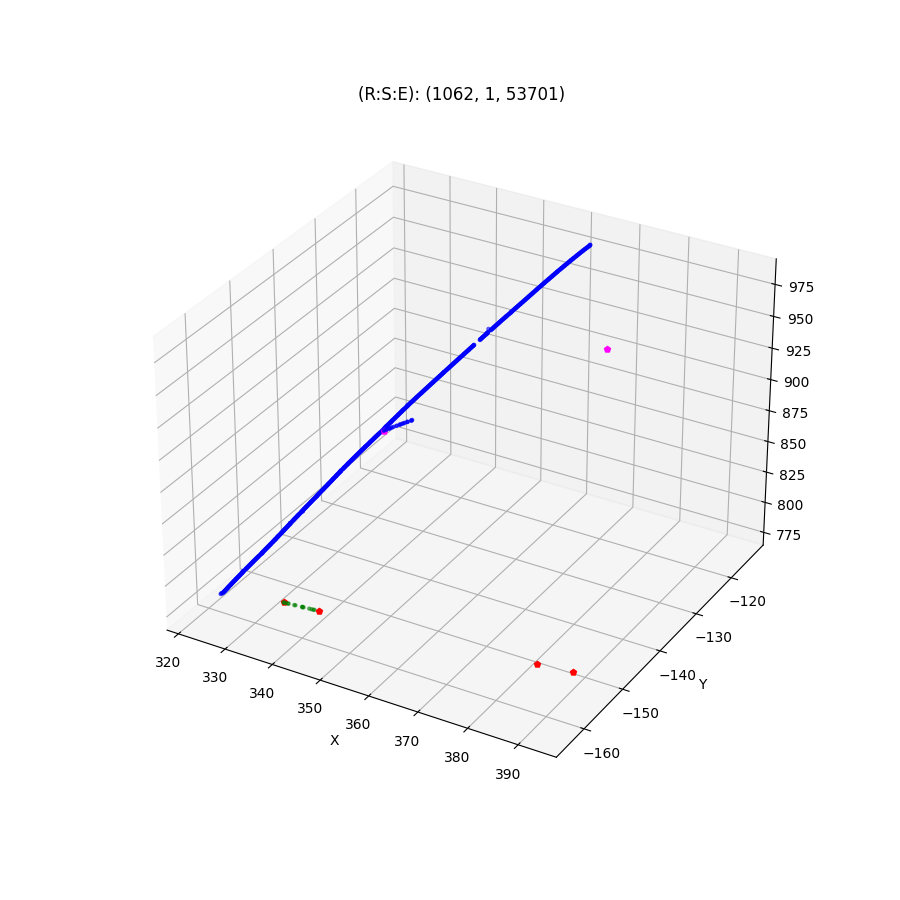

In [21]:
#########################################
# Visualise true hierarchy
#########################################

LINK_INDEX = 23
factor = 48

fig_true = plt.figure(figsize=(9,9))
ax_true = plt.axes(projection='3d')

#ax_true.scatter(recoNuX, recoNuY, recoNuZ, color = "black", s = 30.0)
plt.title('(R:S:E): (' + str(targetRun) + ", " + str(targetSubrun) + ", " + str(targetEvent) + ")")
plt.xlabel('X')
plt.ylabel('Y')

for iParticle in range(nParticles) : 
        
    if not ((pfpTrueTrackID[childPFPIndex[LINK_INDEX]] == pfpTrueTrackID[iParticle]) or (pfpTrueTrackID[parentPFPIndex[LINK_INDEX]] == pfpTrueTrackID[iParticle])) :
        continue

    if (np.array(pfpSpacepointX[iParticle]).shape[0] == 0) :
        continue
    
    #if ((abs(pfpTruePDG[iParticle]) == 211)) :
     #   continue
        
    #if ((abs(pfpTruePDG[iParticle]) == 13)) :
     #   continue
    
    x = np.array(pfpSpacepointX[iParticle])    
    y = np.array(pfpSpacepointY[iParticle])
    z = np.array(pfpSpacepointZ[iParticle])
            
    vertexX = pfpRecoVertexX[iParticle]
    vertexY = pfpRecoVertexY[iParticle]
    vertexZ = pfpRecoVertexZ[iParticle]
    
    ax_true.scatter(x, y, z, color = pdgColours_graph.get(abs(pfpTruePDG[iParticle]), 'tab:gray'), s = 5.0, alpha = 0.5)
    #ax_true.scatter(vertexX, vertexY, vertexZ, color = hierarchyColours.get(pfpTrueVisibleGeneration[iParticle], 'tab:gray'), s = 20.0)
    #ax_true.scatter(endVertexX, endVertexY, endVertexZ, color='g', s = 20.0)

#ax_true.scatter(connectionPointX[LINK_INDEX], connectionPointY[LINK_INDEX], connectionPointZ[LINK_INDEX], color='g', s = 20.0)
#ax_true.scatter(childX[LINK_INDEX], childY[LINK_INDEX], childZ[LINK_INDEX], color='black', marker='p', s = 50.0)



childDirPointX = childX[LINK_INDEX] + (factor * childDX[LINK_INDEX])
childDirPointY = childY[LINK_INDEX] + (factor * childDY[LINK_INDEX])
childDirPointZ = childZ[LINK_INDEX] + (factor * childDZ[LINK_INDEX])

parentDirPointX = parentX[LINK_INDEX] + (factor * parentDX[LINK_INDEX])
parentDirPointY = parentY[LINK_INDEX] + (factor * parentDY[LINK_INDEX])
parentDirPointZ = parentZ[LINK_INDEX] + (factor * parentDZ[LINK_INDEX])

parentStartDirPointX = parentStartX[LINK_INDEX] + (factor * parentStartDX[LINK_INDEX])
parentStartDirPointY = parentStartY[LINK_INDEX] + (factor * parentStartDY[LINK_INDEX])
parentStartDirPointZ = parentStartZ[LINK_INDEX] + (factor * parentStartDZ[LINK_INDEX])

connectionDirPointX = connectionPointX[LINK_INDEX] + (factor * connectionPointDX[LINK_INDEX])
connectionDirPointY = connectionPointY[LINK_INDEX] + (factor * connectionPointDY[LINK_INDEX])
connectionDirPointZ = connectionPointZ[LINK_INDEX] + (factor * connectionPointDZ[LINK_INDEX])

ax_true.scatter(parentX[LINK_INDEX], parentY[LINK_INDEX], parentZ[LINK_INDEX], color='r', marker='p', s = 20.0)
ax_true.scatter(parentDirPointX, parentDirPointY, parentDirPointZ, color='r', marker='p', s = 20.0)

ax_true.scatter(parentStartX[LINK_INDEX], parentStartY[LINK_INDEX], parentStartZ[LINK_INDEX], color='r', marker='p', s = 20.0)
ax_true.scatter(parentStartDirPointX, parentStartDirPointY, parentStartDirPointZ, color='r', marker='p', s = 20.0)

ax_true.scatter(childX[LINK_INDEX], childY[LINK_INDEX], childZ[LINK_INDEX], color='magenta', marker='p', s = 20.0)
ax_true.scatter(childDirPointX, childDirPointY, childDirPointZ, color='magenta', marker='p', s = 20.0)


if (childConnectionLRatio[LINK_INDEX] > -1) :
    ax_true.scatter(connectionPointX[LINK_INDEX], connectionPointY[LINK_INDEX], connectionPointZ[LINK_INDEX], color='black', marker='p', s = 20.0)
    ax_true.scatter(connectionDirPointX, connectionDirPointY, connectionDirPointZ, color='black', marker='p', s = 20.0)

print('childConnectionLRatio:', childConnectionLRatio[LINK_INDEX])
print('overshootStartL:', overshootStartL[LINK_INDEX])
print('childConnectionDCA:', childConnectionDCA[LINK_INDEX])
print('parentConnectionPointOpeningAngle:', parentConnectionPointOpeningAngle[LINK_INDEX])
print('-------------------------------------')

# show plot
plt.show()


In [ ]:
plt.close()